## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [5]:
fname = '09/frame_00667_rgb.jpg'

In [6]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

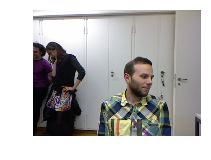

In [7]:
img = open_image(path/fname)
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [9]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [10]:
get_ctr(fname)

tensor([263.9104, 428.5814])

These two numbers are the coordinates of the center of the face.

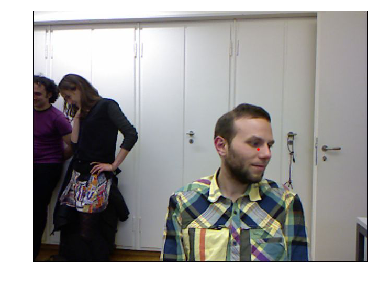

In [11]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

The red dot in the picture above shows the center of the face as per the coordinates. So if we're going to create a model that can find the center of a face, we need a neural network that spits out two numbers. This is not a classification model. These are not two numbers that we look up in a list to find out that they're road or building. They're actual locations.

So far, everything we've done has been a classification model﹣something that created labels or classes. This, for the first time, is what we call a regression model. Regression doesn't mean linear regression, it just means any kind of model where our output is some continuous number or set of numbers. So we need to create an image regression model (i.e. something that can predict these two numbers).

## Creating a dataset

We can actually just say:

* We've got a list of image files.
* They're in a folder.
* We're going to split it according to some function. So in this case, the files they gave us are from videos. So we picked just one folder (13) to be our validation set (i.e. a different person) because a fair validation would be to make sure that it works well on a person that it's never seen before. So our validation set is all going to be a particular person.
* We want to label them using this function that we wrote that basically does the stuff that the readme says to grab the coordinates out of their text files. So that's going to give us the two numbers for every one.
* Create a dataset. This data set, we just tell it what kind of data set it is ﹣ they're going to be a set of points of specific coordinates.
* Do some transforms. Again, I have to say tfm_y=True because that red dot needs to move if I flip or rotate or warp.
* Pick some size.
* Create a data bunch.
* Normalize it.


In [12]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch(num_workers=0).normalize(imagenet_stats)
       )

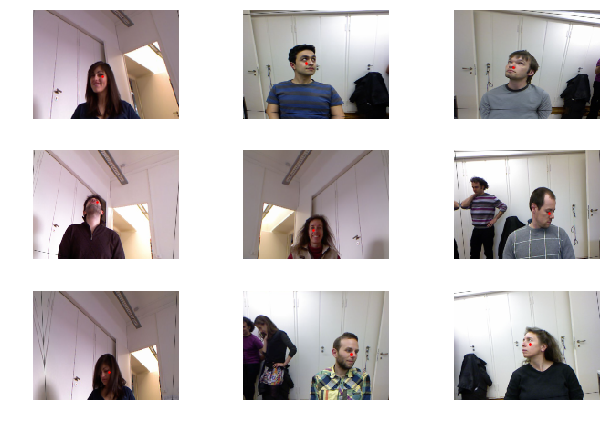

In [13]:
data.show_batch(3, figsize=(9,6))

## Train model

In [14]:
learn = create_cnn(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 92062640.61it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


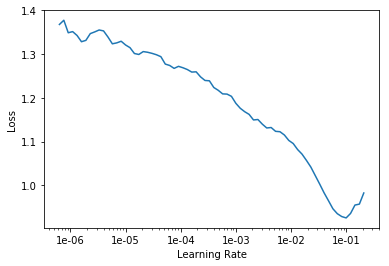

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 2e-2

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.049301,0.035734
2,0.017911,0.004589
3,0.008352,0.003924
4,0.005324,0.000869
5,0.004067,0.002247


In [18]:
learn.save('stage-1')

In [19]:
learn.load('stage-1');

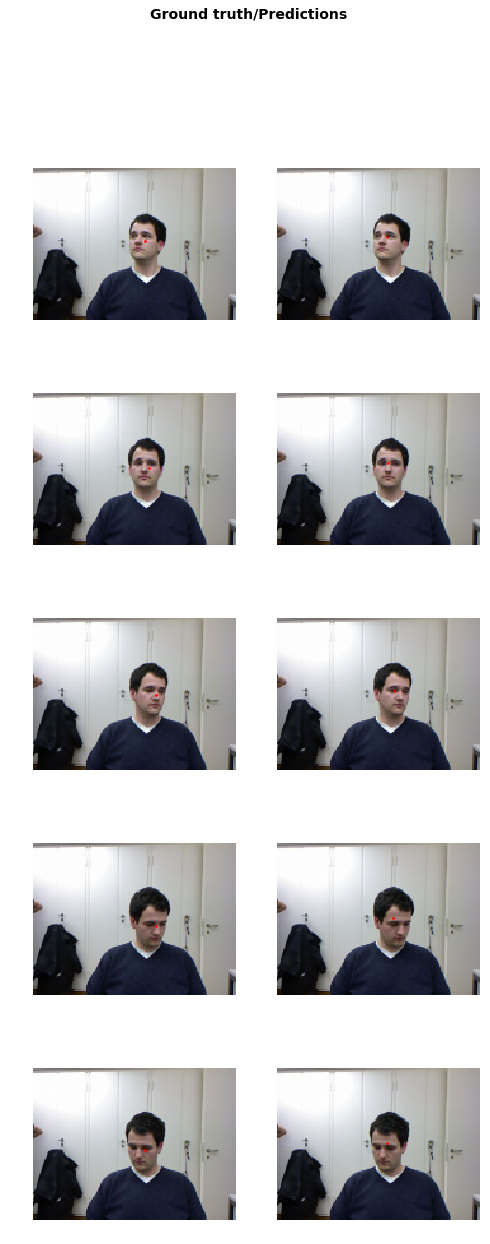

In [20]:
learn.show_results()

## Data augmentation

In [21]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch(num_workers=0).normalize(imagenet_stats)
       )

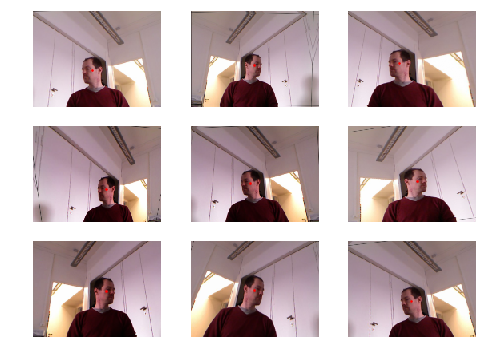

In [22]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))